# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transformation = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    data = datasets.ImageFolder(root=data_dir, transform=transformation)
    
    loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)
    
    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

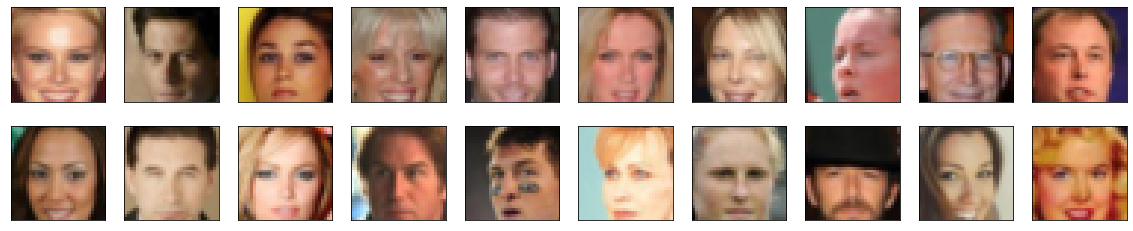

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x    
    return (x*2)-1


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride, batch_norm, bias=False, padding=1):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=bias, padding = padding)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, self.conv_dim, kernel_size=4, stride=2, bias=False, batch_norm=False)
        
        self.conv2 = conv(self.conv_dim, self.conv_dim*2, kernel_size=4, stride=2, bias=False, batch_norm=True)
        
        self.conv3 = conv(self.conv_dim*2, self.conv_dim*4, kernel_size=4, stride=2, bias=False, batch_norm=True)
        
        self.conv4 = conv(self.conv_dim*4, self.conv_dim*8, kernel_size=4, stride=2, bias=False, batch_norm=True)
        
        self.fc = nn.Linear(self.conv_dim*8*2*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2) # no batch norm
        
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
                
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.fc(out)
                
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride, batch_norm, bias=False, padding=1):
    
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=bias, padding=padding)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, 8*2*2*self.conv_dim)
        self.dec1 = deconv(8*self.conv_dim, 4*self.conv_dim, kernel_size=4, stride=2, batch_norm=True)
        self.dec2 = deconv(4*self.conv_dim, 2*self.conv_dim, kernel_size=4, stride=2, batch_norm=True)
        self.dec3 = deconv(2*self.conv_dim, self.conv_dim, kernel_size=4, stride=2, batch_norm=True)
        self.dec4 = deconv(self.conv_dim, 3, 4, 2, padding=1, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        x = x.view(-1, 8*self.conv_dim, 2,2)

        x = F.relu(self.dec1(x))

        x = F.relu(self.dec2(x))

        x = F.relu(self.dec3(x))

        x = torch.tanh(self.dec4(x))
        
        return x
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    
    # TODO: Apply initial weights to convolutional and linear layers
    classname = m.__class__.__name__
    
    if classname == 'Linear' or classname == 'Conv2d' or classname == 'ConvTranspose2d':
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)



## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 16
g_conv_dim = 16
z_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=32, out_features=512, bias=True)
  (dec1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            D_real_output = D(real_images)
            
                    
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            D_fake_output = D(G(z))
            
            d_loss = real_loss(D_real_output) + fake_loss(D_fake_output)
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
              
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
     
            D_fake_output = D(G(z))
            
            g_loss = real_loss(D_fake_output)
            g_loss.backward()
            g_optimizer.step()
                       
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.2116 | g_loss: 0.7102
Epoch [    1/   30] | d_loss: 0.0855 | g_loss: 1.6733
Epoch [    1/   30] | d_loss: 0.0291 | g_loss: 1.4996
Epoch [    1/   30] | d_loss: 0.0281 | g_loss: 1.4717
Epoch [    1/   30] | d_loss: 0.0297 | g_loss: 1.3964
Epoch [    1/   30] | d_loss: 0.0271 | g_loss: 1.3680
Epoch [    1/   30] | d_loss: 0.0193 | g_loss: 1.4150
Epoch [    1/   30] | d_loss: 0.0195 | g_loss: 1.2856
Epoch [    1/   30] | d_loss: 0.0147 | g_loss: 1.3354
Epoch [    1/   30] | d_loss: 0.0170 | g_loss: 1.2408
Epoch [    1/   30] | d_loss: 0.0091 | g_loss: 1.1990
Epoch [    1/   30] | d_loss: 0.0184 | g_loss: 1.4189
Epoch [    1/   30] | d_loss: 0.0171 | g_loss: 1.3877
Epoch [    1/   30] | d_loss: 0.0183 | g_loss: 1.1198
Epoch [    1/   30] | d_loss: 0.0120 | g_loss: 1.2973
Epoch [    1/   30] | d_loss: 0.0245 | g_loss: 1.2432
Epoch [    1/   30] | d_loss: 0.0207 | g_loss: 1.1666
Epoch [    1/   30] | d_loss: 0.0387 | g_loss: 1.0033
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.0405 | g_loss: 1.1803
Epoch [    3/   30] | d_loss: 0.1597 | g_loss: 1.0272
Epoch [    3/   30] | d_loss: 0.1922 | g_loss: 0.8937
Epoch [    3/   30] | d_loss: 0.0865 | g_loss: 0.8538
Epoch [    3/   30] | d_loss: 0.0842 | g_loss: 1.1955
Epoch [    3/   30] | d_loss: 0.0402 | g_loss: 0.7728
Epoch [    3/   30] | d_loss: 0.0444 | g_loss: 1.0993
Epoch [    3/   30] | d_loss: 0.0598 | g_loss: 0.9775
Epoch [    3/   30] | d_loss: 0.0529 | g_loss: 1.2124
Epoch [    3/   30] | d_loss: 0.1335 | g_loss: 0.9671
Epoch [    3/   30] | d_loss: 0.0761 | g_loss: 1.1085
Epoch [    3/   30] | d_loss: 0.1090 | g_loss: 0.8735
Epoch [    3/   30] | d_loss: 0.0326 | g_loss: 0.8341
Epoch [    3/   30] | d_loss: 0.0795 | g_loss: 0.9086
Epoch [    3/   30] | d_loss: 0.0410 | g_loss: 0.7037
Epoch [    3/   30] | d_loss: 0.0815 | g_loss: 1.0091
Epoch [    3/   30] | d_loss: 0.1186 | g_loss: 0.8281
Epoch [    3/   30] | d_loss: 0.0891 | g_loss: 0.8587
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.1277 | g_loss: 0.6610
Epoch [    6/   30] | d_loss: 0.0426 | g_loss: 0.8176
Epoch [    6/   30] | d_loss: 0.1914 | g_loss: 1.0346
Epoch [    6/   30] | d_loss: 0.0861 | g_loss: 0.8711
Epoch [    6/   30] | d_loss: 0.0386 | g_loss: 1.2152
Epoch [    6/   30] | d_loss: 0.0436 | g_loss: 1.0323
Epoch [    6/   30] | d_loss: 0.1353 | g_loss: 0.9806
Epoch [    6/   30] | d_loss: 0.0291 | g_loss: 0.9461
Epoch [    6/   30] | d_loss: 0.0884 | g_loss: 0.9273
Epoch [    6/   30] | d_loss: 0.0834 | g_loss: 0.7665
Epoch [    6/   30] | d_loss: 0.0730 | g_loss: 0.8734
Epoch [    6/   30] | d_loss: 0.0276 | g_loss: 1.3426
Epoch [    6/   30] | d_loss: 0.0542 | g_loss: 1.1987
Epoch [    6/   30] | d_loss: 0.0525 | g_loss: 1.0986
Epoch [    6/   30] | d_loss: 0.0564 | g_loss: 0.6996
Epoch [    6/   30] | d_loss: 0.1188 | g_loss: 1.4282
Epoch [    6/   30] | d_loss: 0.0841 | g_loss: 0.9973
Epoch [    6/   30] | d_loss: 0.0443 | g_loss: 1.0596
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.0752 | g_loss: 1.1339
Epoch [    9/   30] | d_loss: 0.0811 | g_loss: 0.8189
Epoch [    9/   30] | d_loss: 0.0449 | g_loss: 0.8966
Epoch [    9/   30] | d_loss: 0.1129 | g_loss: 1.0346
Epoch [    9/   30] | d_loss: 0.0329 | g_loss: 1.1375
Epoch [    9/   30] | d_loss: 0.0926 | g_loss: 1.0312
Epoch [    9/   30] | d_loss: 0.0446 | g_loss: 1.2104
Epoch [    9/   30] | d_loss: 0.0494 | g_loss: 1.1308
Epoch [    9/   30] | d_loss: 0.0482 | g_loss: 1.0526
Epoch [    9/   30] | d_loss: 0.1410 | g_loss: 1.3041
Epoch [    9/   30] | d_loss: 0.0599 | g_loss: 0.7119
Epoch [    9/   30] | d_loss: 0.0984 | g_loss: 1.3525
Epoch [    9/   30] | d_loss: 0.0573 | g_loss: 0.6863
Epoch [    9/   30] | d_loss: 0.0414 | g_loss: 0.9254
Epoch [    9/   30] | d_loss: 0.0351 | g_loss: 1.2465
Epoch [    9/   30] | d_loss: 0.1817 | g_loss: 1.5098
Epoch [    9/   30] | d_loss: 0.0624 | g_loss: 1.0940
Epoch [    9/   30] | d_loss: 0.0444 | g_loss: 0.8779
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.0541 | g_loss: 0.9252
Epoch [   11/   30] | d_loss: 0.0801 | g_loss: 0.9570
Epoch [   11/   30] | d_loss: 0.0565 | g_loss: 0.7855
Epoch [   11/   30] | d_loss: 0.0697 | g_loss: 1.2965
Epoch [   11/   30] | d_loss: 0.0255 | g_loss: 0.8499
Epoch [   11/   30] | d_loss: 0.0618 | g_loss: 1.2003
Epoch [   11/   30] | d_loss: 0.0424 | g_loss: 1.2572
Epoch [   11/   30] | d_loss: 0.0520 | g_loss: 0.8887
Epoch [   11/   30] | d_loss: 0.1246 | g_loss: 1.3343
Epoch [   11/   30] | d_loss: 0.0448 | g_loss: 1.1744
Epoch [   11/   30] | d_loss: 0.0757 | g_loss: 0.9086
Epoch [   11/   30] | d_loss: 0.0959 | g_loss: 1.0910
Epoch [   11/   30] | d_loss: 0.0953 | g_loss: 0.7798
Epoch [   11/   30] | d_loss: 0.0991 | g_loss: 0.8109
Epoch [   11/   30] | d_loss: 0.0796 | g_loss: 1.0067
Epoch [   11/   30] | d_loss: 0.0831 | g_loss: 0.5897
Epoch [   11/   30] | d_loss: 0.0819 | g_loss: 1.3506
Epoch [   11/   30] | d_loss: 0.0837 | g_loss: 0.9279
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.1589 | g_loss: 0.4018
Epoch [   14/   30] | d_loss: 0.0939 | g_loss: 1.2093
Epoch [   14/   30] | d_loss: 0.0320 | g_loss: 0.9996
Epoch [   14/   30] | d_loss: 0.0257 | g_loss: 0.8404
Epoch [   14/   30] | d_loss: 0.0330 | g_loss: 0.9315
Epoch [   14/   30] | d_loss: 0.0618 | g_loss: 1.0174
Epoch [   14/   30] | d_loss: 0.0528 | g_loss: 0.8288
Epoch [   14/   30] | d_loss: 0.0619 | g_loss: 1.1815
Epoch [   14/   30] | d_loss: 0.0466 | g_loss: 0.8816
Epoch [   14/   30] | d_loss: 0.0431 | g_loss: 1.0113
Epoch [   14/   30] | d_loss: 0.1446 | g_loss: 1.0907
Epoch [   14/   30] | d_loss: 0.2461 | g_loss: 0.9623
Epoch [   14/   30] | d_loss: 0.1042 | g_loss: 1.4778
Epoch [   14/   30] | d_loss: 0.1309 | g_loss: 1.1235
Epoch [   14/   30] | d_loss: 0.0812 | g_loss: 0.7546
Epoch [   14/   30] | d_loss: 0.0894 | g_loss: 0.9049
Epoch [   14/   30] | d_loss: 0.0348 | g_loss: 0.9052
Epoch [   14/   30] | d_loss: 0.0695 | g_loss: 1.0790
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.1009 | g_loss: 1.5601
Epoch [   17/   30] | d_loss: 0.0418 | g_loss: 1.1145
Epoch [   17/   30] | d_loss: 0.0366 | g_loss: 0.9109
Epoch [   17/   30] | d_loss: 0.0477 | g_loss: 0.7764
Epoch [   17/   30] | d_loss: 0.0738 | g_loss: 0.8642
Epoch [   17/   30] | d_loss: 0.0932 | g_loss: 0.7256
Epoch [   17/   30] | d_loss: 0.0823 | g_loss: 0.4686
Epoch [   17/   30] | d_loss: 0.0497 | g_loss: 0.9652
Epoch [   17/   30] | d_loss: 0.1273 | g_loss: 0.8671
Epoch [   17/   30] | d_loss: 0.0553 | g_loss: 0.5475
Epoch [   17/   30] | d_loss: 0.1763 | g_loss: 0.9443
Epoch [   17/   30] | d_loss: 0.0398 | g_loss: 0.8816
Epoch [   17/   30] | d_loss: 0.0514 | g_loss: 0.7730
Epoch [   17/   30] | d_loss: 0.0614 | g_loss: 0.7049
Epoch [   17/   30] | d_loss: 0.0616 | g_loss: 0.7879
Epoch [   17/   30] | d_loss: 0.1002 | g_loss: 0.6953
Epoch [   17/   30] | d_loss: 0.0777 | g_loss: 0.5810
Epoch [   17/   30] | d_loss: 0.1113 | g_loss: 0.9757
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.0850 | g_loss: 1.1806
Epoch [   19/   30] | d_loss: 0.0431 | g_loss: 0.7060
Epoch [   19/   30] | d_loss: 0.0467 | g_loss: 1.1678
Epoch [   19/   30] | d_loss: 0.0406 | g_loss: 1.0012
Epoch [   19/   30] | d_loss: 0.0683 | g_loss: 0.8256
Epoch [   19/   30] | d_loss: 0.0453 | g_loss: 0.6991
Epoch [   19/   30] | d_loss: 0.0292 | g_loss: 1.3241
Epoch [   19/   30] | d_loss: 0.0582 | g_loss: 1.0118
Epoch [   19/   30] | d_loss: 0.1253 | g_loss: 0.8689
Epoch [   19/   30] | d_loss: 0.0387 | g_loss: 1.0908
Epoch [   19/   30] | d_loss: 0.0649 | g_loss: 0.7792
Epoch [   19/   30] | d_loss: 0.0198 | g_loss: 0.9979
Epoch [   19/   30] | d_loss: 0.1049 | g_loss: 0.6932
Epoch [   19/   30] | d_loss: 0.0493 | g_loss: 0.9612
Epoch [   19/   30] | d_loss: 0.1469 | g_loss: 1.1573
Epoch [   19/   30] | d_loss: 0.1118 | g_loss: 1.0378
Epoch [   19/   30] | d_loss: 0.0238 | g_loss: 0.9712
Epoch [   19/   30] | d_loss: 0.1860 | g_loss: 1.4545
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.0327 | g_loss: 0.7702
Epoch [   22/   30] | d_loss: 0.1279 | g_loss: 0.4968
Epoch [   22/   30] | d_loss: 0.0778 | g_loss: 0.7885
Epoch [   22/   30] | d_loss: 0.0378 | g_loss: 0.9704
Epoch [   22/   30] | d_loss: 0.0843 | g_loss: 0.6905
Epoch [   22/   30] | d_loss: 0.1883 | g_loss: 0.4736
Epoch [   22/   30] | d_loss: 0.0559 | g_loss: 0.4869
Epoch [   22/   30] | d_loss: 0.0964 | g_loss: 0.9848
Epoch [   22/   30] | d_loss: 0.0512 | g_loss: 0.7931
Epoch [   22/   30] | d_loss: 0.0753 | g_loss: 0.9187
Epoch [   22/   30] | d_loss: 0.0597 | g_loss: 0.7644
Epoch [   22/   30] | d_loss: 0.0965 | g_loss: 0.8576
Epoch [   22/   30] | d_loss: 0.0421 | g_loss: 1.4455
Epoch [   22/   30] | d_loss: 0.0725 | g_loss: 0.9942
Epoch [   22/   30] | d_loss: 0.0472 | g_loss: 0.9446
Epoch [   22/   30] | d_loss: 0.0642 | g_loss: 1.1190
Epoch [   22/   30] | d_loss: 0.1475 | g_loss: 1.0831
Epoch [   22/   30] | d_loss: 0.0856 | g_loss: 1.0565
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.0644 | g_loss: 1.1000
Epoch [   25/   30] | d_loss: 0.1352 | g_loss: 1.3228
Epoch [   25/   30] | d_loss: 0.1524 | g_loss: 0.7230
Epoch [   25/   30] | d_loss: 0.0579 | g_loss: 0.7791
Epoch [   25/   30] | d_loss: 0.1023 | g_loss: 0.7171
Epoch [   25/   30] | d_loss: 0.1393 | g_loss: 0.7509
Epoch [   25/   30] | d_loss: 0.0929 | g_loss: 0.9610
Epoch [   25/   30] | d_loss: 0.0202 | g_loss: 1.2667
Epoch [   25/   30] | d_loss: 0.0731 | g_loss: 0.7343
Epoch [   25/   30] | d_loss: 0.0237 | g_loss: 1.0422
Epoch [   25/   30] | d_loss: 0.0436 | g_loss: 0.9317
Epoch [   25/   30] | d_loss: 0.0246 | g_loss: 0.8844
Epoch [   25/   30] | d_loss: 0.0301 | g_loss: 0.9524
Epoch [   25/   30] | d_loss: 0.2268 | g_loss: 1.0108
Epoch [   25/   30] | d_loss: 0.1386 | g_loss: 0.8959
Epoch [   25/   30] | d_loss: 0.0366 | g_loss: 0.8196
Epoch [   25/   30] | d_loss: 0.0175 | g_loss: 1.0512
Epoch [   25/   30] | d_loss: 0.0563 | g_loss: 0.8082
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.0422 | g_loss: 0.8644
Epoch [   27/   30] | d_loss: 0.0254 | g_loss: 0.8359
Epoch [   27/   30] | d_loss: 0.0866 | g_loss: 1.5124
Epoch [   27/   30] | d_loss: 0.0560 | g_loss: 0.6710
Epoch [   27/   30] | d_loss: 0.0628 | g_loss: 0.8671
Epoch [   27/   30] | d_loss: 0.0514 | g_loss: 0.9237
Epoch [   27/   30] | d_loss: 0.0202 | g_loss: 0.6812
Epoch [   27/   30] | d_loss: 0.0459 | g_loss: 0.8688
Epoch [   27/   30] | d_loss: 0.0270 | g_loss: 0.9138
Epoch [   27/   30] | d_loss: 0.1037 | g_loss: 0.6067
Epoch [   27/   30] | d_loss: 0.1120 | g_loss: 0.6306
Epoch [   27/   30] | d_loss: 0.0442 | g_loss: 0.4766
Epoch [   27/   30] | d_loss: 0.0779 | g_loss: 1.0956
Epoch [   27/   30] | d_loss: 0.0444 | g_loss: 1.0453
Epoch [   27/   30] | d_loss: 0.0729 | g_loss: 0.5777
Epoch [   27/   30] | d_loss: 0.0331 | g_loss: 0.7422
Epoch [   27/   30] | d_loss: 0.0577 | g_loss: 0.9056
Epoch [   27/   30] | d_loss: 0.0338 | g_loss: 0.9375
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.1134 | g_loss: 0.6816
Epoch [   30/   30] | d_loss: 0.0970 | g_loss: 0.9509
Epoch [   30/   30] | d_loss: 0.0266 | g_loss: 1.5117
Epoch [   30/   30] | d_loss: 0.1858 | g_loss: 0.9055
Epoch [   30/   30] | d_loss: 0.1144 | g_loss: 0.8814
Epoch [   30/   30] | d_loss: 0.0735 | g_loss: 0.7318
Epoch [   30/   30] | d_loss: 0.0209 | g_loss: 0.8188
Epoch [   30/   30] | d_loss: 0.0872 | g_loss: 0.8004
Epoch [   30/   30] | d_loss: 0.0600 | g_loss: 1.1430
Epoch [   30/   30] | d_loss: 0.0562 | g_loss: 0.8273
Epoch [   30/   30] | d_loss: 0.0515 | g_loss: 0.7276
Epoch [   30/   30] | d_loss: 0.0456 | g_loss: 0.9256
Epoch [   30/   30] | d_loss: 0.0407 | g_loss: 0.7544
Epoch [   30/   30] | d_loss: 0.0589 | g_loss: 0.9013
Epoch [   30/   30] | d_loss: 0.1487 | g_loss: 0.7075
Epoch [   30/   30] | d_loss: 0.0290 | g_loss: 1.3876
Epoch [   30/   30] | d_loss: 0.0309 | g_loss: 0.9196
Epoch [   30/   30] | d_loss: 0.0810 | g_loss: 0.8030
Epoch [   30/   30] | d_loss

/home/rjp/Software/anaconda3/envs/faces/lib/python3.8/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

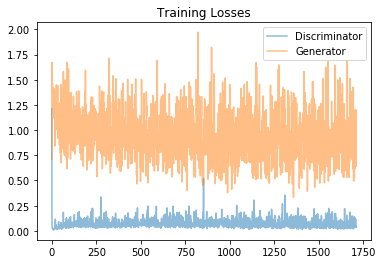

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

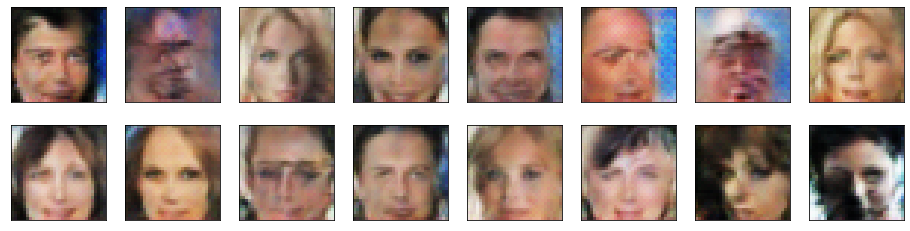

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
- The neural network learned fundamental features of "faceness", such as two eyes, nose, mouth.
- The generator was able to generate faces seen from multiple angles
- The background is (correctly!) generally ignored in the process of image generation and discrimination. I assume that the visible pattern is caused by the nature of non-guided transposed convolutions. The usually appearing blue-ish color is however interesting
- The generated images represent mostly light skin-coloured people, as they made the majority of the training dataset. 
- Although the architecture I used is too simple and shallow to capture all of the features of the face (skin surface, wrinkles), it goes well with the level of detail available in 32x32 minatures. Higher resolution of the output images would make even more impressive result, but on the other hand it would cause by itself higher computational load (more data to process) and it would require deeper network in other to capture more detailed features. That would mean even longer computations and demand for more computational power
- I believe I could use more epochs - the generator was slowly converging, but it would much more time. On the other hand, given the requested resolution 32x32, I'm not sure whether the further time investment would pay off in significant quality improvement
- An alternative would be increasing learning rate of the optimizers


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.